In [2]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import fsolve
import scipy.fftpack as fftpack

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents

from laser_generic.utils import set_initial_susceptibility_randomly
from laser_generic.utils import seed_infections_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [3]:
scenario = pd.DataFrame(data=[["homenode", 1e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 4, "nticks": 36235, "verbose": True, "beta": 0.6, "inf_mean": 8, "cbr": 90, "importation_period": 180, "importation_count": 3})

2024-12-18 04:16:17.478537: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-18 04:16:17.501845: Running the generic model for 36235 ticks…


100%|██████████| 36235/36235 [04:40<00:00, 129.03it/s]


Completed the generic model at 2024-12-18 04:20:58.339503…
Model               :       173,111 µs
Births_ConstantPop  :     2,872,634 µs
Susceptibility      :    29,381,491 µs
Transmission        :   224,068,988 µs
Infection           :    21,245,690 µs
Infect_Random_Agents:        89,979 µs
Total:                  277,831,893 microseconds


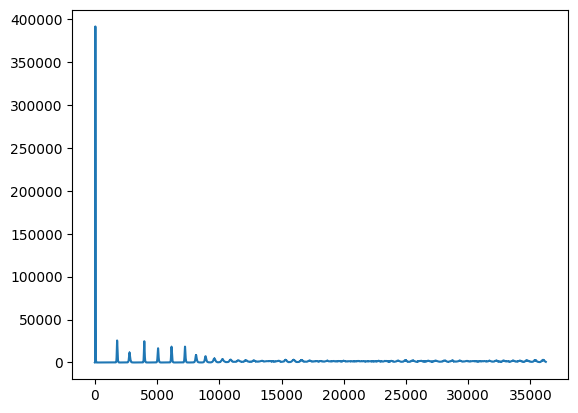

In [4]:
model = Model(scenario, parameters)
model.components = [Births_ConstantPop,
    Susceptibility,
    Transmission,
    Infection,
    Infect_Random_Agents,
]

seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

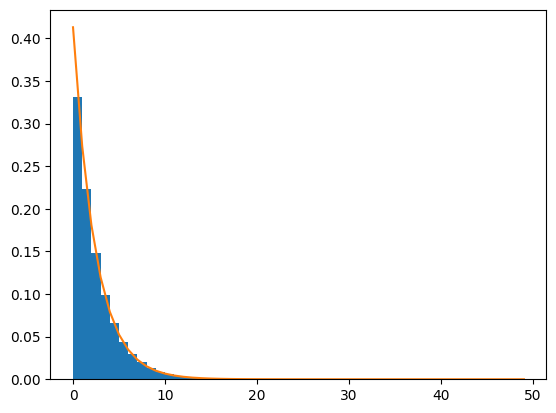

In [17]:
cut = model.population.doi > 25000
plt.hist((model.population.doi[cut] - model.population.dob[cut])/365, bins=np.arange(50), density=True)
mu = ((1+model.params.cbr/1000)**(1/365)-1)
R0 = model.params.beta / (1/model.params.inf_mean + mu)

A = 1/((R0)*mu) / 365
a = np.arange(50)
plt.plot(a, 1/A * np.exp(-a/A))

846.5034790825925

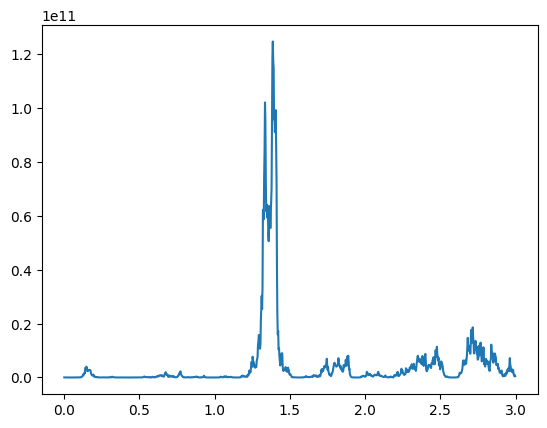

In [18]:
from scipy.stats import expon
from scipy.stats import kstest
cut = model.population.doi > 25000 
cut = cut & ((model.population.doi - model.population.dob)>0)
data = (model.population.doi[cut] - model.population.dob[cut])
params = expon.fit(data)
params
kstest(data, expon.cdf, params)
params

(1.0, 902.6677607926455)

(0.0, 2500.0)

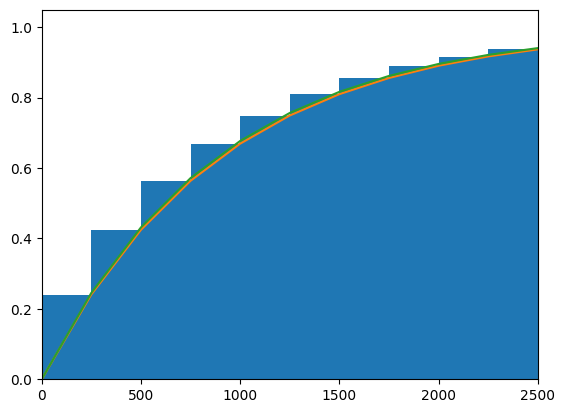

In [19]:
bins = np.arange(0, 50*365, 250)
plt.hist(data, bins=bins, cumulative=True, density=True)
plt.plot(bins, expon.cdf(bins, *params))
plt.plot(bins, expon.cdf(bins, params[0], A*365))
plt.xlim(0, 2500)

In [10]:
params[1]/365

2.473062358336015

array([3.12397177])

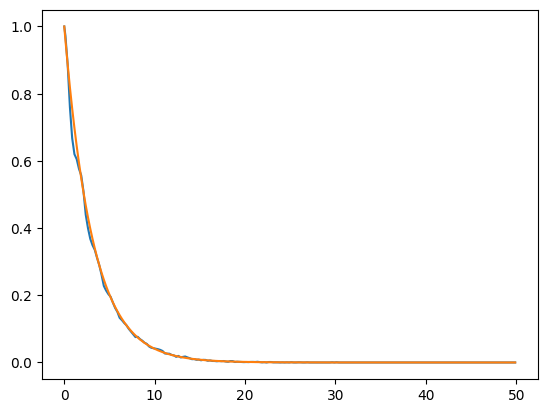

In [12]:
from scipy.optimize import curve_fit
cut = model.population.susceptibility==1
bins = np.linspace(0, 50, 201)
age_years = (np.max(model.population.dob)-model.population.dob)/365
n1 = np.histogram(age_years, bins=bins)[0]
n2 = np.histogram(age_years[cut], bins=bins)[0]
n1[n1==0]=1
y1 = n2/n1
y2 = 1-np.cumsum(n2)/np.sum(n2)
def Scurve(x, A):
    return np.exp(-x/A)

popt, pcov = curve_fit(Scurve, bins[:-1]+np.mean(np.diff(bins)), y1, p0=2.5)
plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))/2], [1, *y1])
#plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))], [1, *(1-np.cumsum(n2)/np.sum(n2))])
plt.plot([0, *bins[:-1]+np.mean(np.diff(bins))/2], [1, *(Scurve(bins[:-1]+np.mean(np.diff(bins))/2, *popt))])
#plt.hist(data/365, bins, density=True, alpha=0.5)
#plt.xlim([0, 10])
popt


In [61]:
#Test that population age distribution is correct
print(expon.fit(age_years))
print(1/(model.params.cbr/1000))


(0.0, 11.11696324109589)
11.11111111111111


In [62]:
print(expon.fit(age_years[cut]))

(0.0, 2.459881997363387)


11.11111111111111

In [ ]:
#OK, testing this is a bit more of a pain, since we are running out to some equilibrium-ish condition.
#With a large initial outbreak from full susceptibility, this could be a long time to equilibrate.
#Partial solution - start us near R-eff=1, but not with the age distribution that we expect, and 
# let it equilibrate towards that age distribution over a couple of generations.  Still not ideal but 
#probably faster than starting from S=1.

scenario = pd.DataFrame(data=[["homenode", 3e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])

cbrs = 15+85*np.random.rand(100)
inf_means = 5+45*np.random.rand(100)
R0s = 1.5+8.5*np.random.rand(100)
output = pd.DataFrame(data={"cbr": cbrs, "inf_mean": inf_means, "R0": R0s})
output["Average_Iage_observed"] = np.nan
output["Average_Iage_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Idata_KStest"] = np.nan
for index, row in output.iterrows():
    mu = ((1+model.params.cbr/1000)**(1/365)-1)
    parameters = PropertySet({
        "seed": 2, 
        "nticks": 18250, 
        "verbose": True, 
        "beta": row['R0']*(mu + 1/row['inf_mean']), 
        "inf_mean": row['inf_mean'], 
        "cbr": row["cbr"], 
        "importation_period": 180, 
        "importation_count": 3})

    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]
    set_initial_susceptibility_randomly(model, 1/row['R0']+.05)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    
    cut = model.population.doi > 10000 
    age_inf = (model.population.doi[cut] - model.population.dob[cut])
    params = expon.fit(age_inf)
    output.loc[index, 'Average_Iage_expected'] = 1/(row['R0']*mu) / 365
    output.loc[index, 'Average_Iage_observed'] = params[1] / 365
    output.loc[index, 'Idata_KStest_obs'] = kstest(age_inf, expon.cdf(params))[0]
    output.loc[index, 'Idata_KStest_exp'] = kstest(age_inf, expon.cdf(output.loc[index, 'Average_Iage_expected']))[0]


    age_total = parameters.nticks-model.population.dob
    params = expon.fit(age_total)
    output.loc[index, 'Average_age_expected'] = 1000/model.params.cbr
    output.loc[index, 'Average_age_observed'] = params[1] / 365
    output.loc[index, 'Adata_KStest_obs'] = kstest(age_total, expon.cdf(params))[0]
    output.loc[index, 'Adata_KStest_exp'] = kstest(age_total, expon.cdf(output.loc[index, 'Average_age_expected'] ))[0]

    


output.to_csv("SIR_output.csv")


2024-12-13 16:09:57.349269: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-13 16:09:57.427558: Running the generic model for 18250 ticks…


 31%|███       | 5604/18250 [00:15<00:35, 351.76it/s]


KeyboardInterrupt: 